In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc
import healpy as hp

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [10]:
func = lambda x, y, a: a*np.exp(-(x**2+y**2)/(2*sigma_in_pixel**2))

In [14]:
x = np.linspace(-15, 15, 31)
y = np.linspace(-15, 15, 31)
xx, yy = np.meshgrid(x, y)

In [16]:
pixel_size = 0.262

--------
## NEA: Gaussian profile

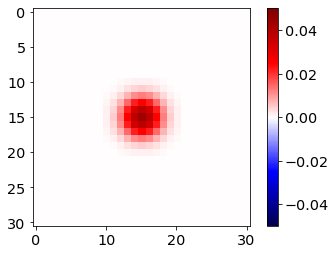

In [32]:
sigma_in_arcsec = 0.5
sigma_in_pixel = sigma_in_arcsec/pixel_size

ff = np.exp(-(xx**2+yy**2)/(2*sigma_in_pixel**2))
ff /= np.sum(ff)

plt.imshow(ff, vmin=-0.05, vmax=0.05, cmap='seismic')
plt.colorbar()
plt.show()

In [33]:
nea = np.sum(ff)**2/np.sum(ff**2) # in unit of number of pixels
nea_in_sqarcsec = nea * (pixel_size**2)
print(nea, nea_in_sqarcsec)

# Analytic formula for Gaussian profile
nea1 = 4 * np.pi * (sigma_in_pixel)**2
print(nea)

45.7664566981788 3.141592653589786
45.7664566981788


## NEA: Moffat profile

In [38]:
def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

0.9923399034117824


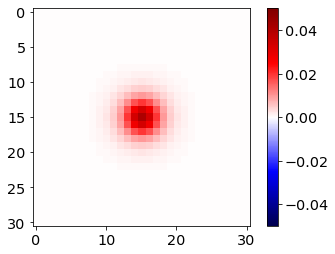

In [43]:
alpha_in_arcsec = 0.9
alpha_in_pixel = alpha_in_arcsec/pixel_size
beta = 2.5
fwhm_in_pixel = alpha_in_pixel * 2 * np.sqrt(2**(1/beta)-1)

ff = get_sb_moffat(np.sqrt(xx**2+yy**2), alpha_in_pixel, beta)
print(np.sum(ff))
ff /= np.sum(ff)

plt.imshow(ff, vmin=-0.05, vmax=0.05, cmap='seismic')
plt.colorbar()
plt.show()

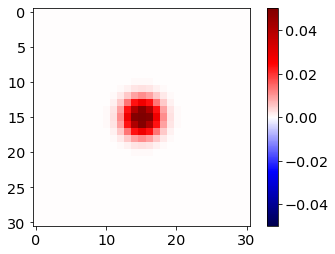

In [41]:
sigma_in_pixel = fwhm_in_pixel/2.3548

ff = np.exp(-(xx**2+yy**2)/(2*sigma_in_pixel**2))
ff /= np.sum(ff)

plt.imshow(ff, vmin=-0.05, vmax=0.05, cmap='seismic')
plt.colorbar()
plt.show()

--------
## No residual background

0.9994994994994995


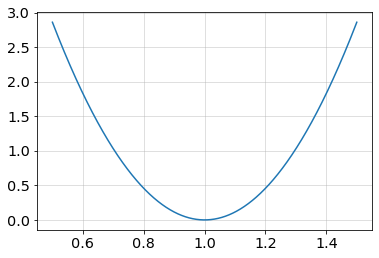

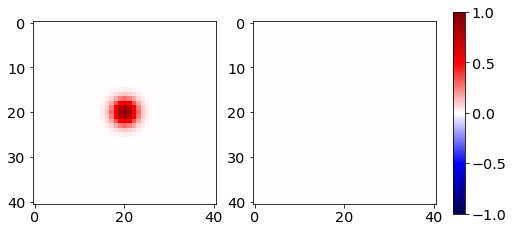

In [11]:
resid = 0.
a = 1
sigma_in_arcsec = 0.5
sigma_in_pixel = sigma_in_arcsec/pixel_size

# ff = a * np.exp(-(xx**2+yy**2)/(2*sigma_in_pixel**2))
ff = a * np.exp(-(xx**2+yy**2)/(2*sigma_in_pixel**2)) + resid

# Chi-squared fitting
a_arr = np.linspace(0.5, 1.5, 1000)
chisq_arr = np.zeros(len(a_arr))
for index, a_value in enumerate(a_arr):
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/func(xx, yy, a)) # model in the denominator
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/ff) # image in the denominator
    chisq = np.sum((ff-func(xx, yy, a=a_value))**2) # least-square fit, i.e. constant variance
    chisq_arr[index] = chisq

a_best = a_arr[np.argmin(chisq_arr)]
print(a_best)
ff_best = func(xx, yy, a=a_best)

# Plot chisq vs a_value
plt.plot(a_arr, chisq_arr)
# plt.axvline(a_best, color='k', ls='--')
plt.grid(alpha=0.5)
plt.show()

# Plot image and residual
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(ff, vmin=-1, vmax=1, cmap='seismic')
tmp = ax[1].imshow(ff-ff_best, vmin=-1, vmax=1, cmap='seismic')
fig.subplots_adjust(left=0.1, right=0.8)
# add an axes, lower left corner in [0.83, 0.15] measured in figure coordinate with axes width 0.02 and height 0.7
cb_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
cbar = fig.colorbar(tmp, cax=cb_ax)

plt.show()

--------
## Add residual background

0.9004004004004004


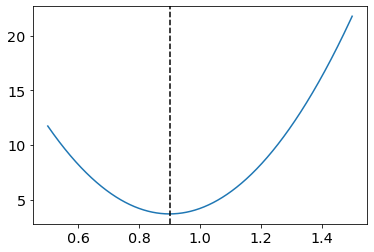

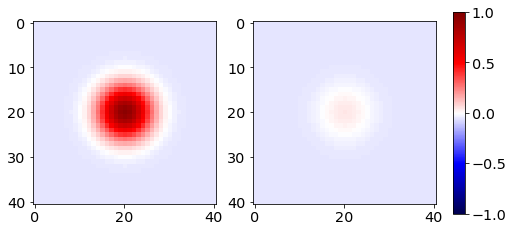

In [6]:
resid = -0.05
a = 1
sigma = 4

# ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2))
ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2)) + resid

# Chi-squared fitting
a_arr = np.linspace(0.5, 1.5, 1000)
chisq_arr = np.zeros(len(a_arr))
for index, a_value in enumerate(a_arr):
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/func(xx, yy, a)) # model in the denominator
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/ff) # image in the denominator
    chisq = np.sum((ff-func(xx, yy, a=a_value))**2) # least-square fit, i.e. constant variance
    chisq_arr[index] = chisq

a_best = a_arr[np.argmin(chisq_arr)]
print(a_best)
ff_best = func(xx, yy, a=a_best)

# Plot chisq vs a_value
plt.plot(a_arr, chisq_arr)
plt.axvline(a_best, color='k', ls='--')
plt.show()

# Plot image and residual
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(ff, vmin=-1, vmax=1, cmap='seismic')
tmp = ax[1].imshow(ff-ff_best, vmin=-1, vmax=1, cmap='seismic')
fig.subplots_adjust(left=0.1, right=0.8)
# add an axes, lower left corner in [0.83, 0.15] measured in figure coordinate with axes width 0.02 and height 0.7
cb_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
cbar = fig.colorbar(tmp, cax=cb_ax)

plt.show()

1.0995995995995997


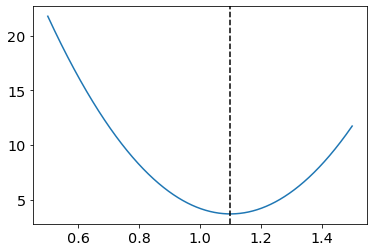

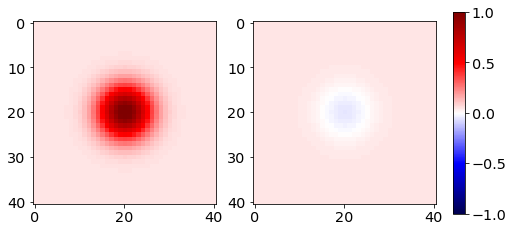

In [7]:
resid = 0.05
a = 1
sigma = 4

# ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2))
ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2)) + resid

# Chi-squared fitting
a_arr = np.linspace(0.5, 1.5, 1000)
chisq_arr = np.zeros(len(a_arr))
for index, a_value in enumerate(a_arr):
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/func(xx, yy, a)) # model in the denominator
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/ff) # image in the denominator
    chisq = np.sum((ff-func(xx, yy, a=a_value))**2) # least-square fit, i.e. constant variance
    chisq_arr[index] = chisq

a_best = a_arr[np.argmin(chisq_arr)]
print(a_best)
ff_best = func(xx, yy, a=a_best)

# Plot chisq vs a_value
plt.plot(a_arr, chisq_arr)
plt.axvline(a_best, color='k', ls='--')
plt.show()

# Plot image and residual
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(ff, vmin=-1, vmax=1, cmap='seismic')
tmp = ax[1].imshow(ff-ff_best, vmin=-1, vmax=1, cmap='seismic')
fig.subplots_adjust(left=0.1, right=0.8)
# add an axes, lower left corner in [0.83, 0.15] measured in figure coordinate with axes width 0.02 and height 0.7
cb_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
cbar = fig.colorbar(tmp, cax=cb_ax)

plt.show()

__Increased background__

1.1996996996996998


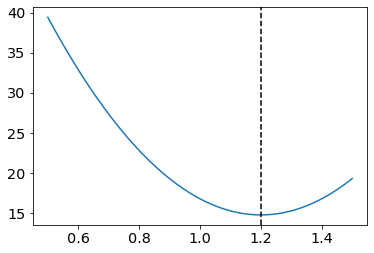

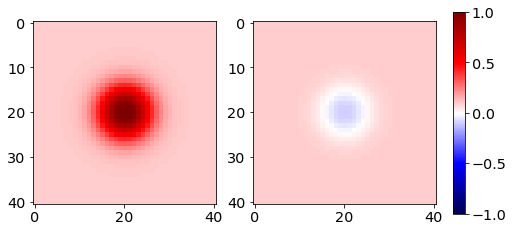

In [8]:
resid = 0.1
a = 1
sigma = 4

# ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2))
ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2)) + resid

# Chi-squared fitting
a_arr = np.linspace(0.5, 1.5, 1000)
chisq_arr = np.zeros(len(a_arr))
for index, a_value in enumerate(a_arr):
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/func(xx, yy, a)) # model in the denominator
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/ff) # image in the denominator
    chisq = np.sum((ff-func(xx, yy, a=a_value))**2) # least-square fit, i.e. constant variance
    chisq_arr[index] = chisq

a_best = a_arr[np.argmin(chisq_arr)]
print(a_best)
ff_best = func(xx, yy, a=a_best)

# Plot chisq vs a_value
plt.plot(a_arr, chisq_arr)
plt.axvline(a_best, color='k', ls='--')
plt.show()

# Plot image and residual
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(ff, vmin=-1, vmax=1, cmap='seismic')
tmp = ax[1].imshow(ff-ff_best, vmin=-1, vmax=1, cmap='seismic')
fig.subplots_adjust(left=0.1, right=0.8)
# add an axes, lower left corner in [0.83, 0.15] measured in figure coordinate with axes width 0.02 and height 0.7
cb_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
cbar = fig.colorbar(tmp, cax=cb_ax)

plt.show()

__More extreme residual__

2.9984984984984986


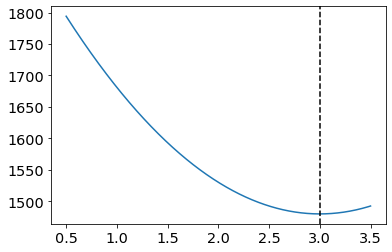

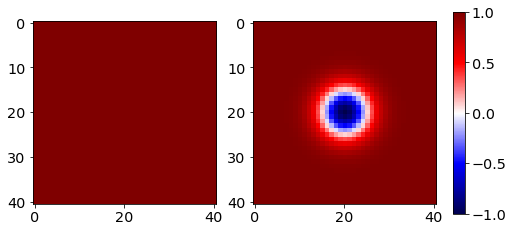

In [9]:
resid = 1
a = 1
sigma = 4

# ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2))
ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2)) + resid

# Chi-squared fitting
a_arr = np.linspace(0.5, 3.5, 1000)
chisq_arr = np.zeros(len(a_arr))
for index, a_value in enumerate(a_arr):
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/func(xx, yy, a)) # model in the denominator
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/ff) # image in the denominator
    chisq = np.sum((ff-func(xx, yy, a=a_value))**2) # least-square fit, i.e. constant variance
    chisq_arr[index] = chisq

a_best = a_arr[np.argmin(chisq_arr)]
print(a_best)
ff_best = func(xx, yy, a=a_best)

# Plot chisq vs a_value
plt.plot(a_arr, chisq_arr)
plt.axvline(a_best, color='k', ls='--')
plt.show()

# Plot image and residual
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(ff, vmin=-1, vmax=1, cmap='seismic')
tmp = ax[1].imshow(ff-ff_best, vmin=-1, vmax=1, cmap='seismic')
fig.subplots_adjust(left=0.1, right=0.8)
# add an axes, lower left corner in [0.83, 0.15] measured in figure coordinate with axes width 0.02 and height 0.7
cb_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
cbar = fig.colorbar(tmp, cax=cb_ax)

plt.show()

__Only background__

0.1996996996996997


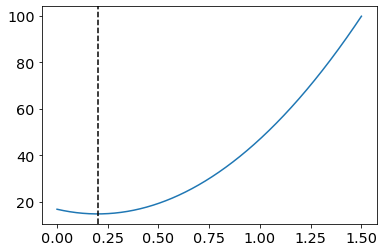

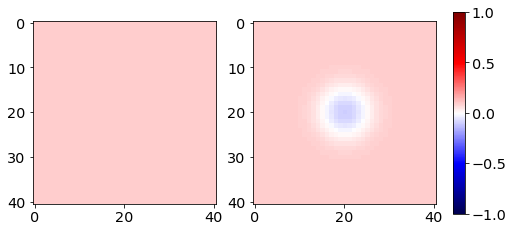

In [10]:
resid = 0.1
a = 0
sigma = 4

# ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2))
ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2)) + resid

# Chi-squared fitting
a_arr = np.linspace(0., 1.5, 1000)
chisq_arr = np.zeros(len(a_arr))
for index, a_value in enumerate(a_arr):
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/func(xx, yy, a)) # model in the denominator
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/ff) # image in the denominator
    chisq = np.sum((ff-func(xx, yy, a=a_value))**2) # least-square fit, i.e. constant variance
    chisq_arr[index] = chisq

a_best = a_arr[np.argmin(chisq_arr)]
print(a_best)
ff_best = func(xx, yy, a=a_best)

# Plot chisq vs a_value
plt.plot(a_arr, chisq_arr)
plt.axvline(a_best, color='k', ls='--')
plt.show()

# Plot image and residual
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(ff, vmin=-1, vmax=1, cmap='seismic')
tmp = ax[1].imshow(ff-ff_best, vmin=-1, vmax=1, cmap='seismic')
fig.subplots_adjust(left=0.1, right=0.8)
# add an axes, lower left corner in [0.83, 0.15] measured in figure coordinate with axes width 0.02 and height 0.7
cb_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
cbar = fig.colorbar(tmp, cax=cb_ax)

plt.show()

__In 2D, the least-square fit of a non-zero constant with a fixed-sigma Gaussian function results in an amplitude of the Gaussian function that is exactly twice the constant value.__

__How about in one dimension?__

1.1216216216216215


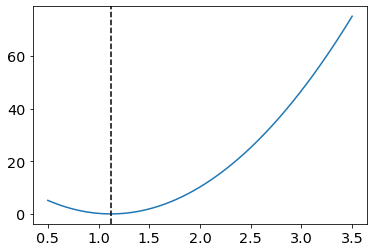

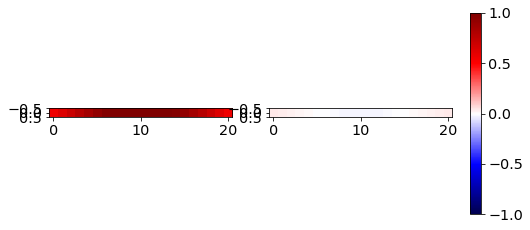

In [11]:
resid = 0.1
a = 1
sigma = 4

x1 = np.linspace(-5, 5, 21)
y1 = [0]
xx1, yy1 = np.meshgrid(x1, y1)

# ff = a * np.exp(-(xx1**2+yy1**2)/(2*sigma**2))
ff = a * np.exp(-(xx1**2+yy1**2)/(2*sigma**2)) + resid

# Chi-squared fitting
a_arr = np.linspace(0.5, 3.5, 1000)
chisq_arr = np.zeros(len(a_arr))
for index, a_value in enumerate(a_arr):
    # chisq = np.sum((ff-func(xx1, yy1, a=a_value))**2/func(xx1, yy1, a)) # model in the denominator
    # chisq = np.sum((ff-func(xx1, yy1, a=a_value))**2/ff) # image in the denominator
    chisq = np.sum((ff-func(xx1, yy1, a=a_value))**2) # least-square fit, i.e. constant variance
    chisq_arr[index] = chisq

a_best = a_arr[np.argmin(chisq_arr)]
print(a_best)
ff_best = func(xx1, yy1, a=a_best)

# Plot chisq vs a_value
plt.plot(a_arr, chisq_arr)
plt.axvline(a_best, color='k', ls='--')
plt.show()

# Plot image and residual
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(ff, vmin=-1, vmax=1, cmap='seismic')
tmp = ax[1].imshow(ff-ff_best, vmin=-1, vmax=1, cmap='seismic')
fig.subplots_adjust(left=0.1, right=0.8)
# add an axes, lower left corner in [0.83, 0.15] measured in figure coordinate with axes width 0.02 and height 0.7
cb_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
cbar = fig.colorbar(tmp, cax=cb_ax)

plt.show()

--------
## NEA

In [12]:
resid = 0.
a = 1
sigma = 4

# ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2))
ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2)) + resid
ff_original = ff.copy()

# NEA value
print(np.sum(ff)**2/np.sum(ff**2)) # single pixel area is 1
# and compare with 2 times the 2D integral
print(4*np.pi*sigma**2)
print()

# Calculating the integral of the 2D Gaussian numerically
print(np.sum(ff)) # single pixel area is 1
# and compare with analytical value
print(2*np.pi*sigma**2)

201.06170678960666
201.06192982974676

100.53090915479032
100.53096491487338


1.1996996996996998


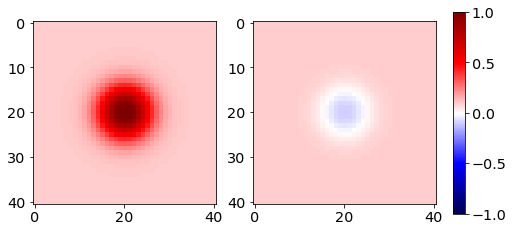

In [13]:
resid = 0.1
a = 1
sigma = 4

# ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2))
ff = a * np.exp(-(xx**2+yy**2)/(2*sigma**2)) + resid

# Chi-squared fitting
a_arr = np.linspace(0.5, 1.5, 1000)
chisq_arr = np.zeros(len(a_arr))
for index, a_value in enumerate(a_arr):
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/func(xx, yy, a)) # model in the denominator
    # chisq = np.sum((ff-func(xx, yy, a=a_value))**2/ff) # image in the denominator
    chisq = np.sum((ff-func(xx, yy, a=a_value))**2) # least-square fit, i.e. constant variance
    chisq_arr[index] = chisq

a_best = a_arr[np.argmin(chisq_arr)]
print(a_best)
ff_best = func(xx, yy, a=a_best)

# # Plot chisq vs a_value
# plt.plot(a_arr, chisq_arr)
# plt.axvline(a_best, color='k', ls='--')
# plt.show()

# Plot image and residual
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(ff, vmin=-1, vmax=1, cmap='seismic')
tmp = ax[1].imshow(ff-ff_best, vmin=-1, vmax=1, cmap='seismic')
fig.subplots_adjust(left=0.1, right=0.8)
# add an axes, lower left corner in [0.83, 0.15] measured in figure coordinate with axes width 0.02 and height 0.7
cb_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
cbar = fig.colorbar(tmp, cax=cb_ax)

plt.show()

In [14]:
# Calculating the integral of the 2D Gaussian numerically
print(np.sum(ff_best) - np.sum(ff_original)) # single pixel area is 1
print(4*np.pi*sigma**2*0.1)

20.07599236874944
20.106192982974676
